In [1]:
import numpy as np
import pandas as pd
from data_manager import get_substring, load_metadata
from score import ProbabilityToScore
from columns_desc_ekata import columns_dict
from fast_ml.model_development import train_valid_test_split
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder
from preprocessors import TemporalVariableTransformerDays, TemporalVariableTransformerYears, VariableNameRegex
# from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import plot_importance
import shap
from yellowbrick.classifier import (
    ClassificationReport,
    DiscriminationThreshold,
    ROCAUC
)

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [2]:
df = pd.read_csv('//Users/ronsnir/Documents/postpay/data/20211203_Postpay_data_appended_Ekata_responses.csv')

In [3]:
df.rename(columns={"Is Fraud": "is_fraud"}, inplace=True)

In [4]:
df.shape

(11631, 35)

In [5]:
df.head()

,Unique ID,Date of Application,Phone Number,Email Address,IP Address,First Name,Last Name,line1,Address City,Phone Country,Is Credit Default,Workflow Decision,is_fraud,email__valid,email__first_seen_days,email__domain_creation_date,email__to_name,ip__risk,ip__risk_score,ip__last_seen_days,ip__geolocation_country_code,ip__geolocation_subdivision,ip__address_distance,phone__valid,phone__line_type,phone__carrier,phone__country_code,phone__last_seen_days,phone__email__first_seen_days,phone__to_name,phone__to_address,address__validity_level,identity_network_score,identity_risk_score,warnings
0,34932,2021-05-30,9.715566e+11,ditto3657777@gmail.com,87.200.168.79,Dilshodbek,Umirov,NaN,Dubai,UAE,1,accept,0.0,True,0.0,1995-08-13,not-found,False,0.523,42,AE,Dubayy [Dubai],NaN,True,mobile,Du,AE,94,0.0,not-found,NaN,missing_address,0.532,148,NaN
1,17965,2021-03-04,9.715298e+11,katovna412@gmail.com,92.98.171.155,NaN,NaN,NaN,NaN,UAE,0,accept,0.0,True,1434.0,1995-08-13,NaN,False,0.087,0,AE,Dubayy [Dubai],NaN,True,mobile,Du,AE,0,0.0,NaN,NaN,missing_address,0.670,65,NaN
2,39143,2021-06-18,9.715279e+11,joycelorrain@yahoo.com,91.74.86.0,Joyce,Cervantes,Marina diamond 1,Dubai Marina (Marsa Dubai),UAE,0,accept,0.0,True,4271.0,1995-01-18,match,False,0.291,0,AE,Dubayy [Dubai],15.0,True,mobile,Du,AE,0,0.0,not-found,country-match,valid_to_city,0.628,147,NaN
3,30026,2021-05-08,9.715051e+11,nithin.prem@hotmail.com,5.30.219.95,Nithin,Prem,NaN,Dubai,UAE,0,accept,0.0,True,3031.0,1996-03-27,match,False,0.092,335,AE,Dubayy [Dubai],NaN,True,mobile,Etisalat,AE,0,0.0,not-found,NaN,missing_address,0.511,17,NaN
4,34394,2021-05-26,9.715622e+11,blo77oms@gmail.com,176.205.221.157,NaN,NaN,NaN,NaN,UAE,0,accept,0.0,True,0.0,1995-08-13,NaN,False,0.071,0,AE,Abu Z¸aby [Abu Dhabi],NaN,True,mobile,Etisalat,AE,125,0.0,NaN,NaN,missing_address,0.636,79,NaN


In [6]:
df["is_fraud"].mean()*100

1.143495830109191

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11631 entries, 0 to 11630
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unique ID                      11631 non-null  int64  
 1   Date of Application            11631 non-null  object 
 2   Phone Number                   11631 non-null  float64
 3   Email Address                  11631 non-null  object 
 4   IP Address                     11631 non-null  object 
 5   First Name                     10581 non-null  object 
 6   Last Name                      10581 non-null  object 
 7   line1                          6504 non-null   object 
 8   Address City                   10581 non-null  object 
 9   Phone Country                  11631 non-null  object 
 10  Is Credit Default              11631 non-null  int64  
 11  Workflow Decision              11631 non-null  object 
 12  is_fraud                       11631 non-null 

In [8]:
df.columns

Index(['Unique ID', 'Date of Application', 'Phone Number', 'Email Address',
       'IP Address', 'First Name', 'Last Name', 'line1', 'Address City',
       'Phone Country', 'Is Credit Default', 'Workflow Decision', 'is_fraud',
       'email__valid', 'email__first_seen_days', 'email__domain_creation_date',
       'email__to_name', 'ip__risk', 'ip__risk_score', 'ip__last_seen_days',
       'ip__geolocation_country_code', 'ip__geolocation_subdivision',
       'ip__address_distance', 'phone__valid', 'phone__line_type',
       'phone__carrier', 'phone__country_code', 'phone__last_seen_days',
       'phone__email__first_seen_days', 'phone__to_name', 'phone__to_address',
       'address__validity_level', 'identity_network_score',
       'identity_risk_score', 'warnings'],
      dtype='object')

In [9]:
# make list of variables  types

# date
date_col = ["email__domain_creation_date"]

# numerical: discrete vs continuous
discrete = [var for var in df.columns if df[var].dtype!='O' and var!='is_fraud' and df[var].nunique()<10 and var not in date_col]
continuous = [var for var in df.columns if df[var].dtype!='O' and var!='is_fraud' and var not in discrete and var not in date_col]

# categorical
categorical = [var for var in df.columns if df[var].dtype=='O' and var not in date_col]

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))
print('There are {} date variables'.format(len(date_col)))

There are 4 discrete variables
There are 10 continuous variables
There are 19 categorical variables
There are 1 date variables


In [10]:
date_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["date"]]
num_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["integer", "numeric"]]
cat_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["categorical"]]
bool_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["boolean"]]
drop_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["general_info"]]

In [11]:
drop_cols_list

['warnings']

In [12]:
df[date_col] = df[date_col].astype('M')
df[discrete + continuous] = df[discrete + continuous].astype('f')
df[categorical] = df[categorical].astype('O')
# returning_unpaid_at_30_df[date_cols_list] = returning_unpaid_at_30_df[date_cols_list].astype('M')
# https://numpy.org/doc/stable/reference/arrays.dtypes.html

In [13]:
df_ekata = df.drop(columns=["Unique ID", "Date of Application", "Phone Number", "Email Address",
       "IP Address", "First Name", "Last Name", "line1", "Address City",
       "Phone Country", "Is Credit Default", "Workflow Decision"])

In [14]:
df_ekata

,is_fraud,email__valid,email__first_seen_days,email__domain_creation_date,email__to_name,ip__risk,ip__risk_score,ip__last_seen_days,ip__geolocation_country_code,ip__geolocation_subdivision,ip__address_distance,phone__valid,phone__line_type,phone__carrier,phone__country_code,phone__last_seen_days,phone__email__first_seen_days,phone__to_name,phone__to_address,address__validity_level,identity_network_score,identity_risk_score,warnings
0,0.0,1.0,0.0,1995-08-13,not-found,0.0,0.523,42.0,AE,Dubayy [Dubai],NaN,1.0,mobile,Du,AE,94.0,0.0,not-found,NaN,missing_address,0.532,148.0,NaN
1,0.0,1.0,1434.0,1995-08-13,NaN,0.0,0.087,0.0,AE,Dubayy [Dubai],NaN,1.0,mobile,Du,AE,0.0,0.0,NaN,NaN,missing_address,0.670,65.0,NaN
2,0.0,1.0,4271.0,1995-01-18,match,0.0,0.291,0.0,AE,Dubayy [Dubai],15.0,1.0,mobile,Du,AE,0.0,0.0,not-found,country-match,valid_to_city,0.628,147.0,NaN
3,0.0,1.0,3031.0,1996-03-27,match,0.0,0.092,335.0,AE,Dubayy [Dubai],NaN,1.0,mobile,Etisalat,AE,0.0,0.0,not-found,NaN,missing_address,0.511,17.0,NaN
4,0.0,1.0,0.0,1995-08-13,NaN,0.0,0.071,0.0,AE,Abu Z¸aby [Abu Dhabi],NaN,1.0,mobile,Etisalat,AE,125.0,0.0,NaN,NaN,missing_address,0.636,79.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11626,0.0,1.0,4589.0,1995-08-13,match,0.0,0.310,715.0,AE,Dubayy [Dubai],NaN,1.0,mobile,Etisalat,AE,14.0,559.0,no-match,NaN,missing_address,0.208,10.0,NaN
11627,0.0,1.0,2819.0,1996-03-27,match,0.0,0.028,356.0,AE,Abu Z¸aby [Abu Dhabi],7.0,1.0,mobile,Etisalat,AE,0.0,0.0,not-found,country-match,valid_to_city,0.479,88.0,NaN
11628,0.0,1.0,1247.0,1995-08-13,no-match,0.0,0.027,252.0,AE,'Ajman,NaN,1.0,landline,du,AE,0.0,0.0,not-found,NaN,missing_address,0.540,77.0,NaN
11629,0.0,1.0,0.0,1995-08-13,not-found,0.0,0.087,0.0,AE,Dubayy [Dubai],NaN,1.0,mobile,Etisalat,AE,0.0,0.0,not-found,NaN,missing_address,0.535,131.0,NaN


In [15]:
# make list of variables  types

# date
date_col_ekata = ["email__domain_creation_date"]

# numerical: discrete vs continuous
discrete_ekata = [var for var in df_ekata.columns if df_ekata[var].dtype!='O' and var!='is_fraud' and df_ekata[var].nunique()<10 and var not in date_col_ekata]
continuous_ekata = [var for var in df_ekata.columns if df_ekata[var].dtype!='O' and var!='is_fraud' and var not in discrete and var not in date_col_ekata]

# categorical
categorical_ekata = [var for var in df_ekata.columns if df_ekata[var].dtype=='O' and var not in date_col_ekata]



print('There are {} discrete variables'.format(len(discrete_ekata)))
print('There are {} continuous variables'.format(len(continuous_ekata)))
print('There are {} categorical variables'.format(len(categorical_ekata)))
print('There are {} date variables'.format(len(date_col_ekata)))

There are 3 discrete variables
There are 8 continuous variables
There are 10 categorical variables
There are 1 date variables


In [16]:
df_ekata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11631 entries, 0 to 11630
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   is_fraud                       11631 non-null  float64       
 1   email__valid                   11631 non-null  float32       
 2   email__first_seen_days         11619 non-null  float32       
 3   email__domain_creation_date    11308 non-null  datetime64[ns]
 4   email__to_name                 10573 non-null  object        
 5   ip__risk                       11631 non-null  float32       
 6   ip__risk_score                 11631 non-null  float32       
 7   ip__last_seen_days             11631 non-null  float32       
 8   ip__geolocation_country_code   11631 non-null  object        
 9   ip__geolocation_subdivision    11579 non-null  object        
 10  ip__address_distance           4443 non-null   float32       
 11  phone__valid   

In [17]:
df_ekata["email__valid"].value_counts()

1.0    11609
0.0       22
Name: email__valid, dtype: int64

In [18]:
df_ekata["email__to_name"].value_counts()

not-found    6717
match        3004
no-match      852
Name: email__to_name, dtype: int64

In [19]:
df_ekata["ip__risk"].value_counts()

0.0    11535
1.0       96
Name: ip__risk, dtype: int64

In [20]:
df_ekata["ip__geolocation_country_code"].value_counts()

AE    11360
GB       52
US       35
SA       23
DE       15
NL       12
KW       11
IN       11
BH        8
EG        8
PH        7
FR        6
AU        6
SG        6
IT        5
OM        4
PK        4
LB        4
AT        4
IE        4
CA        4
HK        3
JO        3
ES        3
UA        3
JP        3
GR        2
PL        2
RU        2
CH        2
FI        2
MV        1
BE        1
RO        1
IL        1
HU        1
ZA        1
TG        1
RS        1
NO        1
IQ        1
MA        1
UZ        1
IS        1
MX        1
CI        1
LU        1
BJ        1
Name: ip__geolocation_country_code, dtype: int64

In [21]:
df_ekata["ip__geolocation_subdivision"].value_counts()

Dubayy [Dubai]               7495
Abu Z¸aby [Abu Dhabi]        2442
Ash Shariqah [Sharjah]        974
'Ajman                        278
Ras al Khaymah                87
Al Fujayrah                    54
Umm al Qaywayn                 29
Al Asimah                     18
Noord-Holland                   8
New York                        8
London, City of                 7
New South Wales                 6
Maharashtra                     6
Hertfordshire                   5
Illinois                        5
Hessen                          5
Bayern                          5
Punjab                          4
New Jersey                      4
California                      4
Causeway Coast and Glens        3
Hounslow                        3
Wien                            3
Masqat                          3
Beyrouth                        3
AI Qahirah                      3
Al A¯simah                     3
AI Iskandariyah                 3
Tower Hamlets                   3
Kerala        

In [22]:
df_ekata["phone__valid"].value_counts()

1.0    11631
Name: phone__valid, dtype: int64

In [23]:
df_ekata["phone__line_type"].value_counts()

mobile      9730
landline    1901
Name: phone__line_type, dtype: int64

In [24]:
df_ekata["phone__carrier"].value_counts()

Etisalat                            6729
Du                                  3825
du                                  1062
Etihad Etisalat Company (mobily)       8
Saudi Telecom Company (stc)            6
Zain                                   1
Name: phone__carrier, dtype: int64

In [25]:
df_ekata["phone__country_code"].value_counts()

AE    11616
SA       15
Name: phone__country_code, dtype: int64

In [26]:
df_ekata["phone__to_name"].value_counts()

not-found    7763
no-match     1718
match        1099
Name: phone__to_name, dtype: int64

In [27]:
df_ekata["phone__to_address"].value_counts()

country-match    4502
Name: phone__to_address, dtype: int64

In [28]:
df_ekata["address__validity_level"].value_counts()

missing_address     5339
valid_to_city       3643
invalid             1586
valid_to_street      721
valid_to_country     204
valid                138
Name: address__validity_level, dtype: int64

In [29]:
df_ekata["warnings"].value_counts()

Email: Invalid top-level-domain (TLD) in address    12
Name: warnings, dtype: int64

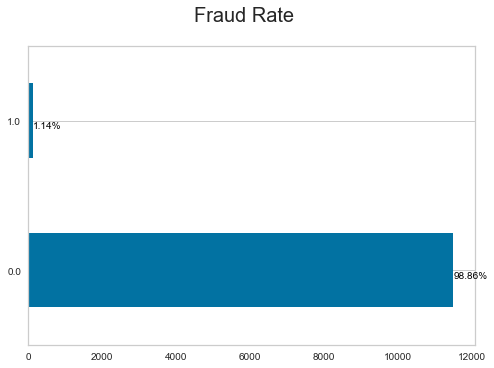

In [30]:
ax = df_ekata["is_fraud"].value_counts().plot(kind="barh")
totals = [i.get_width() for i in ax.patches]
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle("Fraud Rate", fontsize=20)
plt.show()

In [31]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in df_ekata.columns if df_ekata[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

df_ekata[vars_with_na].isnull().mean().sort_values(ascending=False)*100

warnings                         99.896827
ip__address_distance             61.800361
phone__to_address                61.293096
email__to_name                    9.096380
phone__to_name                    9.036196
email__domain_creation_date       2.777061
ip__geolocation_subdivision       0.447081
email__first_seen_days            0.103173
phone__email__first_seen_days     0.103173
dtype: float64

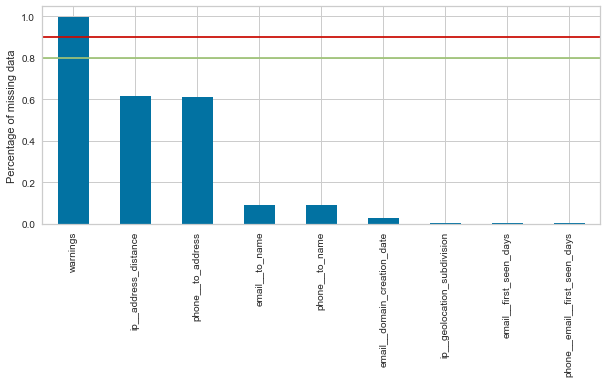

In [32]:
# plot

df_ekata[vars_with_na].isnull().mean().sort_values(
    ascending=False).plot.bar(figsize=(10, 4))
plt.ylabel("Percentage of missing data")
plt.axhline(y=0.90, color="r", linestyle="-")
plt.axhline(y=0.80, color="g", linestyle="-")

plt.show()

In [33]:
# now we can determine which variables, from those with missing data,
# are numerical and which are categorical

cat_na = [var for var in categorical if var in vars_with_na]
num_na = [var for var in [discrete, continuous] if var in vars_with_na]

print("Number of categorical variables with na: ", len(cat_na))
print("Number of numerical variables with na: ", len(num_na))

Number of categorical variables with na:  5
Number of numerical variables with na:  0


In [34]:
def analyse_na_value(df, var):

    # copy of the dataframe, so that we do not override the original data
    # see the link for more details about pandas.copy()
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html
    df = df.copy()

    # let"s make an interim variable that indicates 1 if the
    # observation was missing or 0 otherwise
    df[var] = np.where(df[var].isnull(), "Null", "Not null")

    # let's compare the median in the observations where data is missing
    # vs the observations where data is available

    # determine the median in the groups 1 and 0,
    # and the standard deviation,
    # and we capture the results in a temporary dataset
    tmp = df.groupby(var)["is_fraud"].agg(["mean"])*100
    print(tmp)

    # plot into a bar graph
    tmp.plot(kind="barh", y="mean", legend=False, title="Fraud", color="green")

    plt.show()

                            mean
email__first_seen_days          
Not null                1.144677
Null                    0.000000


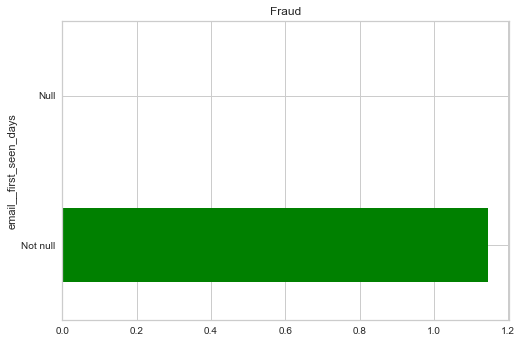

                                 mean
email__domain_creation_date          
Not null                     1.105412
Null                         2.476780


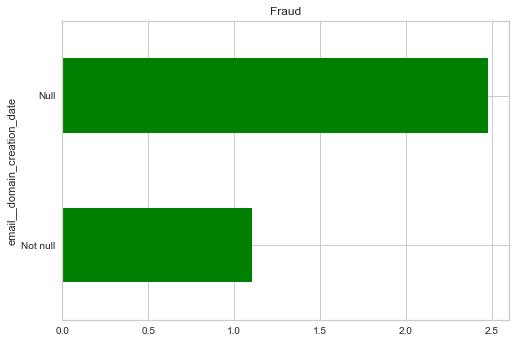

                    mean
email__to_name          
Not null        1.239005
Null            0.189036


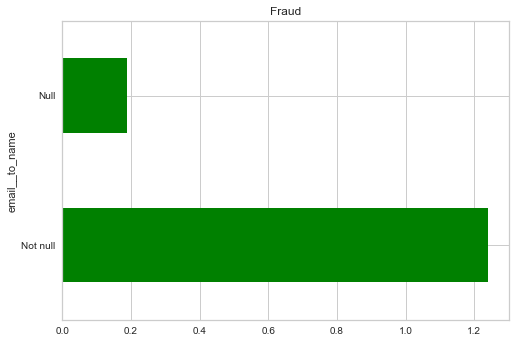

                                 mean
ip__geolocation_subdivision          
Not null                     1.139995
Null                         1.923077


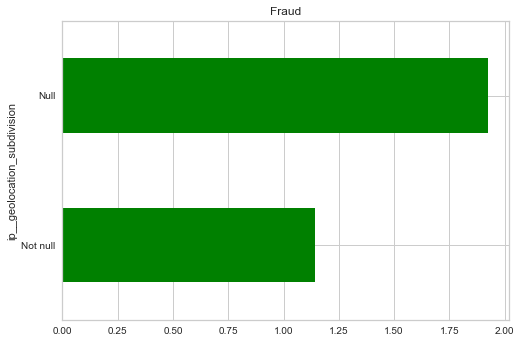

                          mean
ip__address_distance          
Not null              1.710556
Null                  0.792988


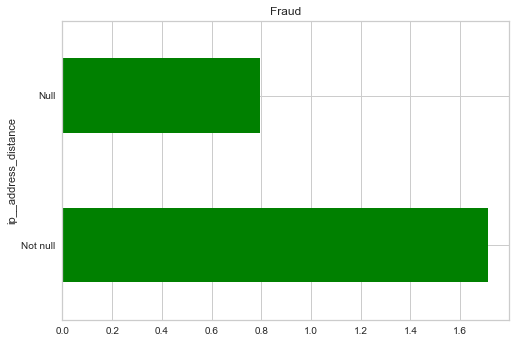

                                   mean
phone__email__first_seen_days          
Not null                       1.144677
Null                           0.000000


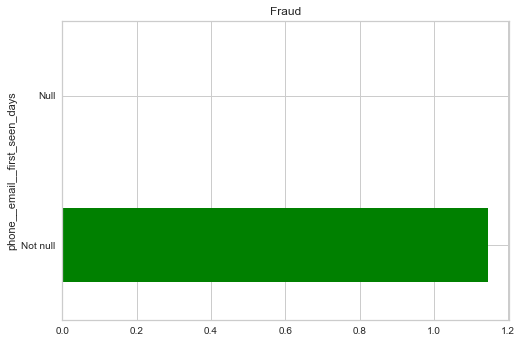

                    mean
phone__to_name          
Not null        1.238185
Null            0.190295


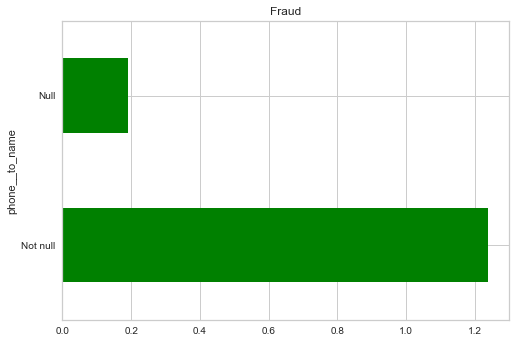

                       mean
phone__to_address          
Not null           1.688139
Null               0.799551


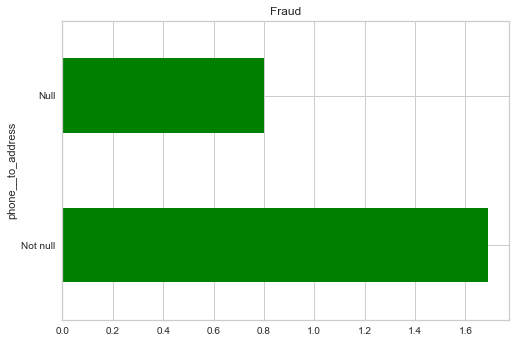

              mean
warnings          
Not null  0.000000
Null      1.144677


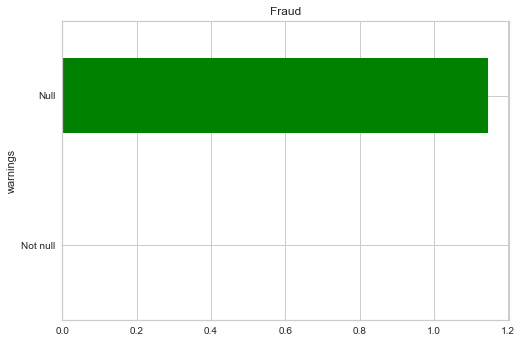

In [35]:
# let's run the function on each variable with missing data

for var in vars_with_na:
    analyse_na_value(df_ekata, var)

In [36]:
# let's visualise the discrete variables

df_ekata[discrete_ekata].head()

,email__valid,ip__risk,phone__valid
0,1.0,0.0,1.0
1,1.0,0.0,1.0
2,1.0,0.0,1.0
3,1.0,0.0,1.0
4,1.0,0.0,1.0


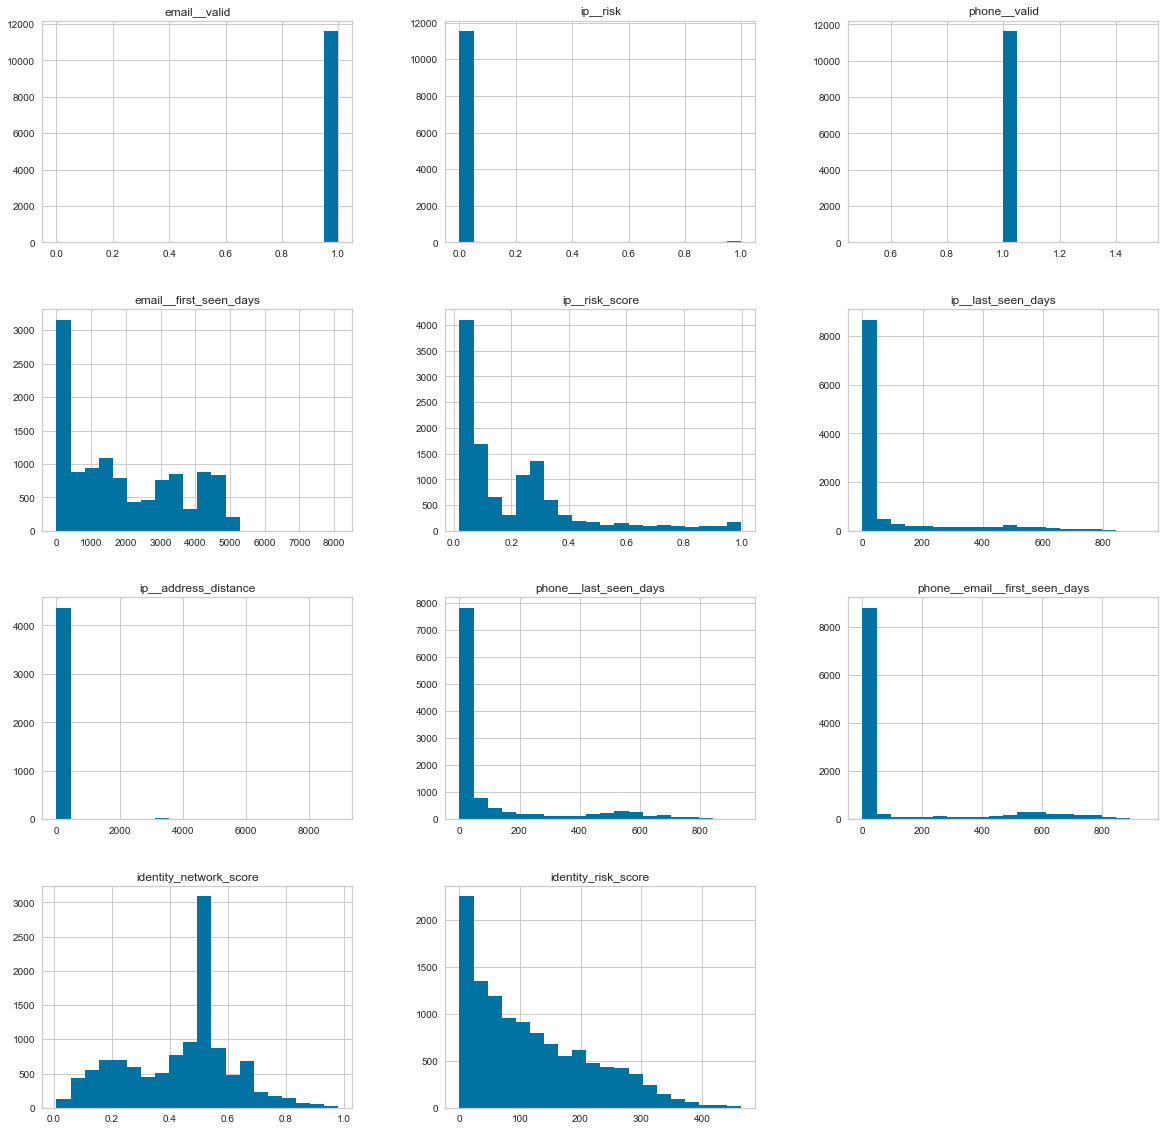

In [37]:
# lets plot histograms for all continuous variables

df_ekata[discrete_ekata + continuous_ekata].hist(bins=20, figsize=(20,20))
plt.show()

In [38]:
print('Number of categorical variables: ', len(categorical_ekata))

Number of categorical variables:  10


<AxesSubplot:>

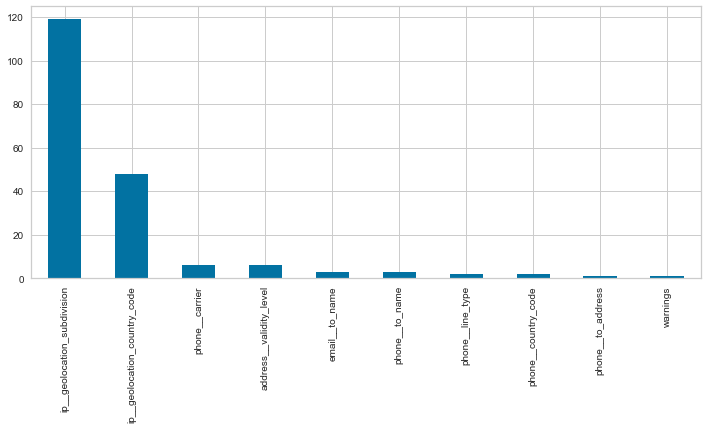

In [39]:
# we count unique categories with pandas nunique() 
# and then plot them in descending order

df_ekata[categorical_ekata].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

In [40]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)['is_fraud'].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 1 % of the observations

for var in categorical_ekata:
    print(analyse_rare_labels(df_ekata, var, 0.01))
    print()

Series([], Name: is_fraud, dtype: float64)

ip__geolocation_country_code
AT    0.000344
AU    0.000516
BE    0.000086
BH    0.000688
BJ    0.000086
CA    0.000344
CH    0.000172
CI    0.000086
DE    0.001290
EG    0.000688
ES    0.000258
FI    0.000172
FR    0.000516
GB    0.004471
GR    0.000172
HK    0.000258
HU    0.000086
IE    0.000344
IL    0.000086
IN    0.000946
IQ    0.000086
IS    0.000086
IT    0.000430
JO    0.000258
JP    0.000258
KW    0.000946
LB    0.000344
LU    0.000086
MA    0.000086
MV    0.000086
MX    0.000086
NL    0.001032
NO    0.000086
OM    0.000344
PH    0.000602
PK    0.000344
PL    0.000172
RO    0.000086
RS    0.000086
RU    0.000172
SA    0.001977
SG    0.000516
TG    0.000086
UA    0.000258
US    0.003009
UZ    0.000086
ZA    0.000086
Name: is_fraud, dtype: float64

ip__geolocation_subdivision
AI Fayyum                    0.000086
AI Iskandariyah              0.000258
AI Qahirah                   0.000258
Abidjan                      0.000086
Al Fujayra

# Pipeline

In [41]:
# load the metadata
metadata = load_metadata("/Users/ronsnir/Documents/postpay/data/metadata_ekata.json")

In [42]:
# Split to train/valid/test
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(
    df=df_ekata,
     target=metadata["split_dict"]["target_col"],
     train_size=metadata["split_dict"]["train_size"],
     valid_size=metadata["split_dict"]["valid_size"],
     test_size=metadata["split_dict"]["test_size"],
     method='random',
     sort_by_col=None,
     random_state=101
     )

In [43]:
X_train.shape, X_valid.shape, X_test.shape

((9304, 22), (1163, 22), (1164, 22))

In [44]:
y_train.mean()*100, y_valid.mean()*100, y_test.mean()*100

(1.1500429922613928, 0.9458297506448838, 1.2886597938144329)

## Configuration

In [45]:
ArbitraryNumberImputer_0_col_list = [c for c in columns_dict if columns_dict[c]["nulls_method"] in ["ArbitraryNumberImputer_0"]]
CategoricalImputer_Missing_col_list = [c for c in columns_dict if columns_dict[c]["nulls_method"] in ["CategoricalImputer_Missing"]]
days_back_col_list = [c for c in columns_dict if columns_dict[c]["imputer"] in ["days_back"]]

In [46]:
CategoricalImputer_Missing_col_list

['email__to_name',
 'ip__geolocation_country_code',
 'ip__geolocation_subdivision',
 'phone__line_type',
 'phone__country_code',
 'phone__to_name',
 'phone__to_address',
 'address__validity_level']

### Create the Pipeline

In [47]:
# set up the pipeline
pipeline = Pipeline([
    # ===== IMPUTATION =====
    # Impute numerical variables with 0
    ('missing_imputation_num_0', ArbitraryNumberImputer(arbitrary_number=0, variables=ArbitraryNumberImputer_0_col_list)),

    # Impute categorical variables with 'Missing'
    ('missing_imputation_cat', CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=CategoricalImputer_Missing_col_list)),


    # == TEMPORAL VARIABLES ====
    ('days_back', TemporalVariableTransformerDays(variables=days_back_col_list, reference_variable="today", variables_first=False)),

    ('drop_features', DropFeatures(features_to_drop=date_cols_list + drop_cols_list)),

    # == CATEGORICAL ENCODING
    ('one_hot_encoder_frequent', OneHotEncoder(top_categories=10,  # you can change this value to select more or less variables
    # we can select which variables to encode
    variables=cat_cols_list,
    drop_last=False)),

    # ===== Column names =====
    # Replace '[,],<' with '_'
    ('variable_name_regex', VariableNameRegex()),
    

])

In [48]:
# train the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation_num_0',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['email__first_seen_days'])),
                ('missing_imputation_cat',
                 CategoricalImputer(variables=['email__to_name',
                                               'ip__geolocation_country_code',
                                               'ip__geolocation_subdivision',
                                               'phone__line_type',
                                               'phone__country_code',
                                               'phone__to_name',
                                               'phone__to_address',
                                               'address__val...
                ('drop_features',
                 DropFeatures(features_to_drop=['email__domain_creation_date',
                                                'warnings'])),
                ('one_hot_encoder_freque

In [49]:
# transform the data
X_train_transformed = pipeline.transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)
X_test_transformed = pipeline.transform(X_test)

In [50]:
X_train_transformed.isnull().mean()

email__valid                                          0.000000
email__first_seen_days                                0.000000
ip__risk                                              0.000000
ip__risk_score                                        0.000000
ip__last_seen_days                                    0.000000
ip__address_distance                                  0.612532
phone__valid                                          0.000000
phone__last_seen_days                                 0.000000
phone__email__first_seen_days                         0.000967
identity_network_score                                0.000000
identity_risk_score                                   0.000000
email__domain_creation_date_days                      0.027730
email__to_name_not-found                              0.000000
email__to_name_match                                  0.000000
email__to_name_Missing                                0.000000
email__to_name_no-match                               0

In [51]:
X_train_transformed.head()

,email__valid,email__first_seen_days,ip__risk,ip__risk_score,ip__last_seen_days,ip__address_distance,phone__valid,phone__last_seen_days,phone__email__first_seen_days,identity_network_score,identity_risk_score,email__domain_creation_date_days,email__to_name_not-found,email__to_name_match,email__to_name_Missing,email__to_name_no-match,ip__geolocation_country_code_AE,ip__geolocation_country_code_GB,ip__geolocation_country_code_US,ip__geolocation_country_code_SA,ip__geolocation_country_code_NL,ip__geolocation_country_code_DE,ip__geolocation_country_code_KW,ip__geolocation_country_code_IN,ip__geolocation_country_code_EG,ip__geolocation_country_code_PH,ip__geolocation_subdivision_Dubayy [Dubai],ip__geolocation_subdivision_Abu Z¸aby [Abu Dhabi],ip__geolocation_subdivision_Ash Shariqah [Sharjah],ip__geolocation_subdivision_'Ajman,ip__geolocation_subdivision_Ras al Khaymah,ip__geolocation_subdivision_Al Fujayrah,ip__geolocation_subdivision_Missing,ip__geolocation_subdivision_Umm al Qaywayn,ip__geolocation_subdivision_Al Asimah,ip__geolocation_subdivision_Noord-Holland,phone__line_type_mobile,phone__line_type_landline,phone__carrier_Etisalat,phone__carrier_Du,phone__carrier_du,phone__carrier_Etihad Etisalat Company (mobily),phone__carrier_Saudi Telecom Company (stc),phone__carrier_Zain,phone__country_code_AE,phone__country_code_SA,phone__to_name_not-found,phone__to_name_no-match,phone__to_name_match,phone__to_name_Missing,phone__to_address_Missing,phone__to_address_country-match,address__validity_level_missing_address,address__validity_level_valid_to_city,address__validity_level_invalid,address__validity_level_valid_to_street,address__validity_level_valid_to_country,address__validity_level_valid
8645,1.0,2941.0,0.0,0.078,382.0,NaN,1.0,0.0,0.0,0.458,122.0,9613.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0
768,1.0,632.0,0.0,0.048,0.0,14.0,1.0,226.0,226.0,0.192,84.0,9613.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0
4235,1.0,3486.0,0.0,0.238,0.0,NaN,1.0,438.0,0.0,0.431,75.0,9613.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0
8227,1.0,4151.0,0.0,0.554,6.0,NaN,1.0,6.0,23.0,0.089,5.0,9613.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0
2765,1.0,0.0,0.0,0.034,0.0,NaN,1.0,0.0,0.0,0.531,259.0,9613.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0


In [52]:
constant_params = {"learning_rate": 0.1, "max_depth": 5, "n_estimators": 500, "random_state": 101, "early_stopping_rounds": 10}
model = xgb.XGBClassifier(**constant_params)

In [54]:
eval_set = [(X_train_transformed, y_train), (X_valid_transformed, y_valid)]
model.fit(X_train_transformed, y_train, eval_metric="auc", eval_set=eval_set, verbose=True)

ValueError: feature_names must be string, and may not contain [, ] or <

In [55]:
X_train_transformed.columns

Index(['email__valid', 'email__first_seen_days', 'ip__risk', 'ip__risk_score',
       'ip__last_seen_days', 'ip__address_distance', 'phone__valid',
       'phone__last_seen_days', 'phone__email__first_seen_days',
       'identity_network_score', 'identity_risk_score',
       'email__domain_creation_date_days', 'email__to_name_not-found',
       'email__to_name_match', 'email__to_name_Missing',
       'email__to_name_no-match', 'ip__geolocation_country_code_AE',
       'ip__geolocation_country_code_GB', 'ip__geolocation_country_code_US',
       'ip__geolocation_country_code_SA', 'ip__geolocation_country_code_NL',
       'ip__geolocation_country_code_DE', 'ip__geolocation_country_code_KW',
       'ip__geolocation_country_code_IN', 'ip__geolocation_country_code_EG',
       'ip__geolocation_country_code_PH',
       'ip__geolocation_subdivision_Dubayy [Dubai]',
       'ip__geolocation_subdivision_Abu Z¸aby [Abu Dhabi]',
       'ip__geolocation_subdivision_Ash Shariqah [Sharjah]',
       'ip